In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
# 绘图
import seaborn as sns
import matplotlib.pyplot as plt
# 因子分析
from factor_analyzer import FactorAnalyzer

In [3]:
# 创造一个储存tracks的类
class tracks:
    def __init__(self, tracks_id):
        self.tracks_id = tracks_id
        self.tracks_path = '../data/' + f"{tracks_id:02d}"
        # 分别存放tracks,tracksMeta,recordingMeta三个csv
        self.df_tracks = pd.read_csv(self.tracks_path + '_tracks.csv')
        self.df_meta = pd.read_csv(self.tracks_path + '_tracksMeta.csv')
        self.df_record = pd.read_csv(self.tracks_path + '_recordingMeta.csv')
        # 把以上三者都用DataFrame储存
        for i in self.df_tracks, self.df_meta, self.df_record:
            np.array(i)
            pd.DataFrame(i)

        self.averageXVelocity = np.mean(abs(self.df_tracks.xVelocity)) # 平均速度取时均而非车均
        self.init_frame = []  # 记录各车出现的第一帧
        self.init_frame_index = [] # 记录各车出现的第一帧所对应的index
        self.veh_num = 1  # 记录当前的tracks出现的车辆数
        self.init_frame_index += [0]  # 因为id是从1开始的，拿两个0来添数
        self.init_frame_index += [0]
        self.init_frame += [0] # 同理凑数，但id为1的车出现时为第一帧
        self.init_frame += [1]
        for i in range(0, len(self.df_tracks)): # 填充上面的list
            if(self.df_tracks.id[i] != self.veh_num):
                self.init_frame_index += [i]
                self.init_frame += [self.df_tracks.frame[i]]
                self.veh_num = self.df_tracks.id[i]  # 要求id连续递增
        if(self.veh_num != len(self.df_meta)):
            print(tracks_id,self.veh_num,len(self.df_meta),'该tracks的车辆数目有误')

        self.lanechange_id = []  # 储存刚好发生过一次变道的车辆的id
        df_temp = []  # 用来临时储存刚好发生过一次变道的车辆的数据
        # 把发生过变道的track提取并储存
        for i in range(1, self.veh_num + 1):
            if (self.df_meta.numLaneChanges[i - 1] == 1):  # 刚好发生过一次变道
                self.lanechange_id += [i]
                # 提取刚好发生过一次变道的车辆的数据
                df_temp = self.df_tracks[self.df_tracks.id == i]
                path_temp = './track_data/' + \
                    f"{tracks_id:02d}" + '_' + f"{i:04d}" + '.csv'
                df_temp.to_csv(path_temp, index=False,)  # 储存

        # 这里处理车道相关，使车道id与其中心线y值一一对应，以便于后面判断车辆是否变道
        # 先将upper_lane车道线提取并储存为list
        upper_lane_markings = np.fromstring(
            self.df_record.upperLaneMarkings[0], sep=";"),
        upper_lane_markings = upper_lane_markings[0].tolist()
        num_upper_lane = len(upper_lane_markings) - 1  # upper车道数
        # 随后取各车道中心线的y值
        upper_lane = []
        for i in range(0, num_upper_lane):
            upper_lane += [10000*(upper_lane_markings[i] +
                                  upper_lane_markings[i+1])/20000]
        # 对lower_lane车道线采取同样操作
        lower_lane_markings = np.fromstring(
            self.df_record.lowerLaneMarkings[0], sep=";"),
        lower_lane_markings = lower_lane_markings[0].tolist()
        num_lower_lane = len(lower_lane_markings) - 1
        lower_lane = []
        for i in range(0, num_lower_lane):
            lower_lane += [10000*(lower_lane_markings[i] +
                                  lower_lane_markings[i+1])/20000]
        upper_and_lower_lane = upper_lane + lower_lane
        # 接下来要将laneid与对应的车道的中心y值一一配对
        mid_lane_marking_temp = {}  # 用这个dict记录各id对应的车道的中心y值
        list_laneid = list(set(self.df_tracks.laneId))
        sorted(list_laneid)
        sorted(upper_and_lower_lane)
        for i in range(0, len(list_laneid)):
            mid_lane_marking_temp[list_laneid[i]] = upper_and_lower_lane[i]
            # 这建立在laneid越小，y值越小的假设上，后面设置一处报错来防止其他情况
        self.mid_lane_marking = mid_lane_marking_temp

        print(f'{tracks_id}已完成初始化')
    
    def search(self, id, frame):
    # 检索效率太低了，写了个函数加速
        position = self.init_frame_index[id] + frame - self.init_frame[id]
        return self.df_tracks.iloc[position]

    # 20230304 对于找不到前车、后车的情况，之前是直接取200，现在改成取nan，这样统计量更准确
    def distance(self, id1, id2, current_frame):
    # 求id1和id2的车在current_frame帧下的距离，如果有缺失量或者过大则用一个上限替代
        if id1 == 0 or id2 == 0:
            # 取一个较大的值作为上限
            return np.nan
        else:
            # 检索到当前帧下两个id的车的数据
            x1 = self.search(id1, current_frame).x
            x2 = self.search(id2, current_frame).x
            dis = abs(x1 - x2) if (abs(x1 - x2) < 200) else 200
            return dis

    def relative_x_velocity(self, id1, id2, current_frame):
    # 求id1和id2的车的相对速度，如果有一个缺失的话则用平均速度代替缺失者
        if id1 == 0:
            v1 = abs(self.averageXVelocity)
        else:
            v1 = abs(self.search(id1, current_frame).xVelocity)
        if id2 == 0:
            v2 = abs(self.averageXVelocity)
        else:
            v2 = abs(self.search(id2, current_frame).xVelocity)
        return v1 - v2
    
    def relative_T(self, id1, id2, current_frame):
        # 求id1和id2的车的车头时距，注意是id2的车追逐id1的车，因此只在乎id2的xVelocity
        dis = self.distance(id1, id2, current_frame)
        if id2 == 0:
            v2 = abs(self.averageXVelocity)
        else:
            v2 = abs(self.search(id2, current_frame).xVelocity)
        return (dis/v2) # nan/v2 = nan

changan = tracks(1)

1已完成初始化


In [4]:
# 创造一个储存变道了的汽车数据的类
class one_track:   
    def __init__(self, id, tracks):
        self.id = id  # 注意这个id是车辆的id
        self.tracks_id = tracks.tracks_id # tracks_id是tracks类的id，也就是场景的id
        self.track = pd.read_csv(
            './track_data/' + f"{tracks.tracks_id:02d}" + '_' + f"{id:04d}" + '.csv')
        self.num_frame = len(self.track)
        self.lane_id = self.track.laneId # 注意是一个series
        self.father = tracks
        self.averageXVelocity = tracks.averageXVelocity
        self.init_frame = self.track.frame[0]
        self.mid_lane_marking = tracks.mid_lane_marking
        # 下面求一些tracks中本身未给出但要计算统计量的一些参数，目前为4*3=12个
        # 这个if本来是为了提高效率的，但是由于改的太频繁了，因此先让它永真
        if 'averageXVelocity1' not in self.track.columns:
            # 四个相对x距离，与当前道路和换道目标道路的前后车的相对距离
            # 默认换道时目标道路的Alongside是没有车的，不然应该换不了道
            rela_preceding_x = []
            rela_following_x= []
            rela_target_preceding_x = []
            rela_target_following_x = []
            # 四个相对x速度
            rela_preceding_x_velocity= []
            rela_following_x_velocity = []
            rela_target_preceding_x_velocity = []
            rela_target_following_x_velocity = []
            # 四个车头时距
            preceding_T = []
            following_T = []
            target_preceding_T = []
            target_following_T = []
            left_or_right = 0 # 0为左转，1为右转

            # 因为考虑到有三条路的可能，这里要辨识左转还是右转
            # drivingDirection = 1意味着x速度为负
            if tracks.df_meta.drivingDirection[id - 1] == 1 and\
                self.lane_id[0] > self.lane_id[self.num_frame - 1]:
                left_or_right = 1
            elif tracks.df_meta.drivingDirection[id - 1] == 2 and\
                self.lane_id[0] < self.lane_id[self.num_frame - 1]:
                left_or_right = 1
            for i in range(0,self.num_frame):
                frame = self.track.frame[i]
                if self.lane_id[i] == self.lane_id[0]:
                    # 对每一帧求这四个位置（前、后、目标前、目标后）的车的id，这是因为可能在换道中出现变化
                    preceding_id = self.track.precedingId[i]
                    following_id = self.track.followingId[i]
                    target_preceding_id = self.track.leftPrecedingId[i] if left_or_right == 0 \
                        else self.track.rightPrecedingId[i]
                    target_following_id = self.track.leftFollowingId[i] if left_or_right == 0 \
                        else self.track.rightFollowingId[i]
                else:
                    target_preceding_id = self.track.precedingId[i]
                    target_following_id = self.track.followingId[i]
                    preceding_id = self.track.leftPrecedingId[i] if left_or_right == 0 \
                        else self.track.rightPrecedingId[i]
                    following_id = self.track.leftFollowingId[i] if left_or_right == 0 \
                        else self.track.rightFollowingId[i]
                    
                # 在获得了四个位置的车的id后，求出这12个值
                rela_preceding_x += [tracks.distance(self.id, preceding_id, frame)]
                rela_following_x += [tracks.distance(self.id, following_id, frame)]
                rela_target_preceding_x += [tracks.distance(self.id, target_preceding_id, frame)]
                rela_target_following_x += [tracks.distance(self.id, target_following_id, frame)]

                rela_preceding_x_velocity += [tracks.relative_x_velocity(self.id, preceding_id, frame)]
                rela_following_x_velocity += [tracks.relative_x_velocity(self.id, following_id, frame)]
                rela_target_preceding_x_velocity += [tracks.relative_x_velocity(self.id, target_preceding_id, frame)]
                rela_target_following_x_velocity += [tracks.relative_x_velocity(self.id, target_following_id, frame)]
                
                preceding_T += [tracks.relative_T(preceding_id, self.id, frame)]
                following_T += [tracks.relative_T(self.id, following_id, frame)]
                target_preceding_T += [tracks.relative_T(target_preceding_id, self.id, frame)]
                target_following_T += [tracks.relative_T(self.id, target_following_id, frame)]
            # 简单粗暴的给track这个dataframe添加列的环节
            # 如果采用dict的方法应该会更优雅一点（不过这里命名法不同）
            self.track['relaPrecedingX'] = rela_preceding_x
            self.track['relaFollowingX'] = rela_following_x
            self.track['relaTargetPrecedingX'] = rela_target_preceding_x
            self.track['relaTargetFollowingX'] = rela_target_following_x
            self.track['relaPrecedingXVelocity'] = rela_preceding_x_velocity
            self.track['relaFollowingXVelocity'] = rela_following_x_velocity
            self.track['relaTargetPrecedingXVelocity'] = rela_target_preceding_x_velocity
            self.track['relaTargetFollowingXVelocity'] = rela_target_following_x_velocity
            self.track['precedingT'] = preceding_T
            self.track['followingT'] = following_T
            self.track['targetPrecedingT'] = target_preceding_T
            self.track['targetFollowingT'] = target_following_T
            self.track['averageXVelocity'] = self.father.averageXVelocity

            self.track.to_csv('./track_data/' + f"{tracks.tracks_id:02d}" + '_' + f"{id:04d}" + '.csv')
            

    # 判断函数的某一帧在变道过程中
    def if_lane_change(self, frame):
        # 提取所在的车道中心线y值
        mid_lane = self.mid_lane_marking[self.track.laneId[frame]]
        y_temp = self.track.y[frame] + self.track.height[frame]/2
        # 通过车辆离中心线的距离和y方向的速度来判断是否在变道 (这个方法有待改进)
        if (abs(y_temp - mid_lane) >= 0.6) | (abs(self.track.yVelocity[frame]) >= 0.5):
            if(abs(y_temp - mid_lane) >= 2.5):
                print("laneid越小y值越小的假设不正确")
                exit(1)
            return True
            # 目前看起来不用排除变道变了一半又放弃了的情况
        return False

    # 判断变道的开始帧、换道临界帧、结束帧
    # 换道临界帧直接根据laneid的变化可以看出，再从临界前后推直到不满足if_lane_change()
    def get_lane_change_frame(self):
        begin_frame = 0
        change_frame = 0
        end_frame = self.num_frame - 1
        # if_lane_change(begin_frame) = if_lane_change(end_frame) = True
        # 这是因为方便处理第一帧和最后一帧就已经开始换道了
        for i in range(1, self.num_frame):
            if self.lane_id[i] != self.lane_id[i - 1]:
                change_frame = i  # 注意这个与实际帧的标号是不一样的，从0开始
                # change_frame为刚好变道后的第一帧
                break
        for i in range(change_frame, self.num_frame):
            if(self.if_lane_change(i) != True):
                end_frame = i + 1  # end_frame为变道彻底结束后的第一帧
                break
        for i in range(0, change_frame - 1):
            if(self.if_lane_change(change_frame - 1 - i) != True):
                begin_frame = change_frame - 2 - i  # change_frame为变道完全开始前的第一帧
                break
        return(begin_frame, change_frame, end_frame)

    # 判断该条track是否同时包含完整的跟车和换道，判定方法为看帧数是否足够多
    # 由于if_lane_change比较严格，前后各补10帧给换道，再要求前面有30帧的跟车过程
    # 如果成功则将文件存储到'./follow_and_change/'
    def follow_and_change(self):
        (begin_frame, change_frame, end_frame) = self.get_lane_change_frame()
        if(begin_frame > 70) & (self.num_frame - end_frame > 10):
            df_change = self.track[begin_frame - 10: end_frame + 10]
            df_follow = self.track[0:begin_frame - 10]
            path_temp = './follow_and_change_2/' + \
                f"{self.tracks_id:02d}" + '_' + f"{self.id:04d}"
            df_change.to_csv(path_temp + '_change.csv', index=False,)
            df_follow.to_csv(path_temp + '_follow.csv', index=False,)
            df_change.to_csv('./change_2/' + \
                f"{self.tracks_id:02d}" + '_' + f"{self.id:04d}"+ '.csv', index=False,)
            print(f"{self.tracks_id:02d}_{self.id:04d}通过了")
        else:
            print(f"排除{self.tracks_id:02d}_{self.id:04d}")

    
b = one_track(142, changan)

In [5]:
# 创造一个计算统计量的函数
def get_change_stat(tracks_id, id):
    # 参数包括所在的tracks类的id和轨迹车辆的id
    path = './follow_and_change_2/' + f"{tracks_id:02d}_{id:04d}_change.csv"
    df = pd.read_csv(path)
    num_frame = len(df)
    x = abs(df.x[num_frame - 1] - df.x[0]) # x方向的总位移
    y = abs(df.y[num_frame - 1] - df.y[0]) # y方向的总位移
    xVelocity = abs(np.mean(df.xVelocity))
    yVelocity = abs(np.mean(df.yVelocity))
    averageXVelocity = df.averageXVelocity[0] # 整个道路上的平均x速度
    time = len(df)
    # 四个相对位置
    relativePrecedingX = abs(np.mean(1/df.relaPrecedingX))
    relativeFollowingX = abs(np.mean(1/df.relaFollowingX))
    relativeTargetPrecedingX = abs(np.mean(1/df.relaTargetPrecedingX))
    relativeTargetFollowingX = abs(np.mean(1/df.relaTargetFollowingX))
    # 四个相对速度
    relativePrecedingXVelocity = abs(np.mean(df.relaPrecedingXVelocity))
    relativeFollowingXVelocity = abs(np.mean(df.relaFollowingXVelocity))
    relativeTargetPrecedingXVelocity = abs(np.mean(df.relaTargetPrecedingXVelocity))
    relativeTargetFollowingXVelocity = abs(np.mean(df.relaTargetFollowingXVelocity))
    # 四个车头时距
    precedingHeadway = abs(np.mean(df.precedingT))
    followingHeadway = abs(np.mean(df.followingT))
    targetPrecedingHeadway = abs(np.mean(df.targetPrecedingT))
    targetFollowingHeadway = abs(np.mean(df.targetFollowingT))
    out = {'x':x, 'y':y, 'xV':xVelocity, 't': time, 'yV':yVelocity, 'aXV':averageXVelocity,
           'rPX':relativePrecedingX, 'rFX':relativeFollowingX,
           'rTPX':relativeTargetPrecedingX, 'rTFX':relativeTargetFollowingX,
           'rPXV':relativePrecedingXVelocity, 'rFXV':relativeFollowingXVelocity,
           'rTPXV':relativeTargetPrecedingXVelocity, 'rTFXV':relativeTargetFollowingXVelocity,
           'pH':precedingHeadway, 'fH':followingHeadway,
           'tPH':targetPrecedingHeadway, 'tFX':targetFollowingHeadway,
           }
    df_out = pd.DataFrame(out,index= [f'{tracks_id:02d}{id:04d}'])
    return df_out

df = get_change_stat(1,11)
df[df.index == '010011']

,x,y,xV,t,yV,aXV,rPX,rFX,rTPX,rTFX,rPXV,rFXV,rTPXV,rTFXV,pH,fH,tPH,tFX
010011,113.73,3.42,24.942087,115,0.745565,30.11114,0.075237,NaN,0.046236,0.01133,1.640518,5.169053,8.367244,10.996174,0.553848,NaN,1.052817,2.516145


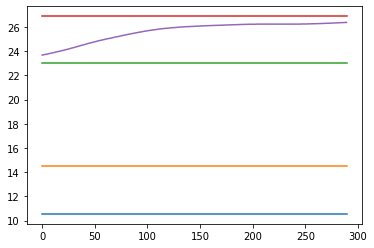

In [8]:
# 变道轨迹可视化
b = one_track(142, changan)
# for i in range(0,len(b.track)):
#   print(b.if_lane_change(i))
track_picture = b.track.y[0:b.num_frame] + b.track.height[0:b.num_frame]/2
b.mid_lane_marking
lane2 = [10.55]*b.num_frame
lane3 = [14.51]*b.num_frame
lane5 = [22.98]*b.num_frame
lane6 = [26.88]*b.num_frame
lane2 = pd.DataFrame(lane2)
lane3 = pd.DataFrame(lane3)
lane6 = pd.DataFrame(lane6)
lane5 = pd.DataFrame(lane5)
plt.plot(lane2)
plt.plot(lane3)
plt.plot(lane5)
plt.plot(lane6)
plt.plot(track_picture)
plt.show()


In [15]:
# 遍历highd数据
# 26号场景不太好，直接忽略
# 43出bug了也忽略

# for j in range(44,61):
#     changan =  tracks(j)
#     for i in range(0, len(changan.lanechange_id)):
#         b = one_track(changan.lanechange_id[i], changan)
#         b.follow_and_change()

44已完成初始化
排除44_0020
排除44_0026
44_0027通过了
44_0031通过了
排除44_0056
排除44_0059
排除44_0061
44_0062通过了
排除44_0070
排除44_0073
排除44_0085
排除44_0089
排除44_0107
排除44_0110
44_0121通过了
44_0126通过了
排除44_0127
排除44_0134
排除44_0140
排除44_0168
排除44_0186
44_0190通过了
排除44_0194
排除44_0204
排除44_0206
排除44_0207
排除44_0232
44_0249通过了
排除44_0257
44_0267通过了
排除44_0269
44_0271通过了
排除44_0299
排除44_0301
44_0302通过了
44_0306通过了
44_0311通过了
排除44_0312
排除44_0328
排除44_0329
排除44_0345
排除44_0349
排除44_0353
排除44_0364
排除44_0370
排除44_0376
排除44_0384
排除44_0397
44_0399通过了
44_0416通过了
排除44_0468
44_0476通过了
排除44_0482
44_0483通过了
44_0484通过了
排除44_0491
排除44_0495
排除44_0509
排除44_0513
44_0518通过了
排除44_0521
44_0522通过了
排除44_0525
排除44_0527
排除44_0528
排除44_0545
排除44_0546
44_0557通过了
排除44_0560
44_0563通过了
排除44_0568
排除44_0572
44_0576通过了
排除44_0578
44_0586通过了
44_0593通过了
44_0594通过了
排除44_0595
排除44_0629
排除44_0630
44_0631通过了
排除44_0633
排除44_0635
排除44_0638
排除44_0639
排除44_0644
44_0673通过了
排除44_0702
排除44_0727
排除44_0739
排除44_0790
44_0791通过了
44_0795通过了
排除44_0796
排除44_0797
排除44_0824
44

In [20]:
# 遍历所有轨迹并将统计数据合成到一个stat
filePath = './change_2/'
csv_files = os.listdir(filePath)
stat = pd.DataFrame()
for i in csv_files:
    txt = i.split('_')
    tracks_id = int(txt[0])
    txt1 = txt[1].split('.')
    id = int(txt1[0])
    stat = stat.append(get_change_stat(tracks_id, id))
stat.to_csv('stat_2.csv')

C:\Users\JYB\AppData\Local\Temp/ipykernel_12864/52556889.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stat = stat.append(get_change_stat(tracks_id, id))
C:\Users\JYB\AppData\Local\Temp/ipykernel_12864/52556889.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stat = stat.append(get_change_stat(tracks_id, id))
C:\Users\JYB\AppData\Local\Temp/ipykernel_12864/52556889.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stat = stat.append(get_change_stat(tracks_id, id))
C:\Users\JYB\AppData\Local\Temp/ipykernel_12864/52556889.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stat = stat.append(get_change_stat(tracks_id, id))
